# Plot temperature response over time

## Imports:

import numpy as np

In [1]:
import xarray as xr
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

%load_ext autoreload
%autoreload 2

### Paths input data

In [2]:
from ar6_ch6_rcmipfigs.constants import OUTPUT_DATA_DIR, RESULTS_DIR

# PATH_DATASET = OUTPUT_DATA_DIR + '/forcing_data_rcmip_models.nc'
# PATH_DT = OUTPUT_DATA_DIR / '/dT_data_rcmip_models.nc'
PATH_DT = OUTPUT_DATA_DIR / 'dT_data_RCMIP_recommendation.nc'

/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs
/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs/data_in


#### Uncertainty data from Chris

In [3]:
PATH_DT_UNCERTAINTY = OUTPUT_DATA_DIR / 'dT_uncertainty_data_FaIR_chris_ed02-3.nc'

## Set values:

In [4]:
first_y = '1750'
last_y = '2100'

**Set reference year for temperature change:**

In [5]:
ref_year = '2019'

In [6]:
FIGURE_DIR = RESULTS_DIR / 'figures_recommendation/'

TABLE_DIR = RESULTS_DIR / 'tables_recommendation/'

In [7]:
from pathlib import Path

Path(FIGURE_DIR).mkdir(parents=True, exist_ok=True)
Path(TABLE_DIR).mkdir(parents=True, exist_ok=True)

In [8]:
percentile = 'percentile'
climatemodel = 'climatemodel'
scenario = 'scenario'
variable = 'variable'
time = 'time'

### Define variables to look at:

In [9]:
# variables to plot:
variables_erf_comp = [
    'aerosol-total-with_bc-snow',
    'ch4',
    'o3',
    'HFCs',
]

scenarios_fl_370 = ['ssp370', 'ssp370-lowNTCF-aerchemmip', 'ssp370-lowNTCF-gidden'  # Due to mistake here
                    ]

### Scenarios:

In [10]:
scenarios_fl = ['ssp119',
                'ssp126',
                'ssp245',
                'ssp334',
                'ssp370',
                'ssp370-lowNTCF-aerchemmip',
                'ssp370-lowNTCF-gidden',
                'ssp585']

In [11]:
median = 'median'
perc5 = '5th percentile'
perc95 = '95th percentile'
recommendation = 'recommendation'

## Open dataset:

### Integrate:
The code below opens the file generated in [2_compute_delta_T.ipynb](2_compute_delta_T.ipynb) by integrating

\begin{align*} 
\Delta T (t) &= \int_0^t ERF(t') IRF(t-t') dt' \\
\end{align*}

where IRF is the impulse response function and ERF is the effective radiative forcing from RCMIP. 

In [12]:
ds_DT = xr.open_dataset(PATH_DT)
ds_uncertainty = xr.open_dataset(PATH_DT_UNCERTAINTY)

In [13]:
for var in variables_erf_comp:
    da5 = ds_uncertainty.sel(variable=var, scenario='ssp585')['p05-p50']
    da95 = ds_uncertainty.sel(variable=var, scenario='ssp585')['p95-p50']
    da5.plot(label=var)
    da95.plot(label=var)

In [14]:
from ar6_ch6_rcmipfigs.utils.plot import get_var_nicename

<IPython.core.display.Javascript object>

hallo


In [15]:
name_deltaT = 'Delta T'

## Plot $\Delta T$ from ref year:

In [16]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ar6_ch6_rcmipfigs.utils.plot import get_cmap_dic, get_ls_dic, trans_scen2plotlabel, get_scenario_c_dic, \
    get_scenario_ls_dic
from ar6_ch6_rcmipfigs.utils.misc_func import make_folders
from ar6_ch6_rcmipfigs.utils.plot import trans_scen2plotlabel
import numpy as np

In [17]:
from ar6_ch6_rcmipfigs.utils.plot import get_scenario_c_dic, \
    get_scenario_ls_dic


def get_fig_ax_tot(fgsize=None, nrows=2, ncols=3, rows_tot=0, cols_tot=2, tot_first=True, orientation='horizontal'):
    """
    Makes figure for total plot
    :param orientation: horizontal or vertical
    :param tot_first: plot with total comes first or second
    :param cols_tot:
    :param rows_tot:
    :param ncols:
    :param nrows:
    :param fgsize:
    :return:
    """
    if fgsize is None:
        fgsize = [11, 4.4]
    fg = plt.figure(constrained_layout=False, figsize=fgsize, dpi=150)
    if orientation == 'horizontal':
        _cols = ncols + cols_tot
        _rows = nrows
    else:
        _cols = ncols  # + cols_tot
        _rows = nrows + rows_tot

    spec2 = gridspec.GridSpec(ncols=_cols, nrows=_rows, figure=fg)
    com_axs = []
    if tot_first:
        if orientation == 'horizontal':
            all_ax = fg.add_subplot(spec2[:, 0:cols_tot])
            for i in np.arange(nrows):
                for j in np.arange(ncols):
                    com_axs.append(fg.add_subplot(spec2[i, cols_tot + j]))
        else:

            all_ax = fg.add_subplot(spec2[0:rows_tot, :])
            for i in np.arange(nrows):
                for j in np.arange(ncols):
                    com_axs.append(fg.add_subplot(spec2[rows_tot + i, j]))
    else:
        if orientation == 'horizontal':
            all_ax = fg.add_subplot(spec2[:, (-cols_tot):])
            for i in np.arange(nrows):
                for j in np.arange(ncols):
                    com_axs.append(fg.add_subplot(spec2[i, j]))
        else:

            all_ax = fg.add_subplot(spec2[(-rows_tot):, :])
            for i in np.arange(nrows):
                for j in np.arange(ncols):
                    com_axs.append(fg.add_subplot(spec2[i, j]))

    return fg, com_axs, all_ax


def get_fig_ax_tot_old(fgsize=None):
    """
    Makes figure for total plot
    :param fgsize:
    :return:
    """
    if fgsize is None:
        fgsize = [13, 12]
    _fig = plt.figure(constrained_layout=False, figsize=fgsize, dpi=140)
    spec2 = gridspec.GridSpec(ncols=12, nrows=4, figure=_fig)
    com_axs = []
    for i in np.arange(2):
        for j in np.arange(3):
            if i == 1 and j == 2: continue
            com_axs.append(_fig.add_subplot(spec2[i, j * 4:(j + 1) * 4]))
    all_ax = _fig.add_subplot(spec2[2:, 2:10])
    return _fig, com_axs, all_ax


def fix_ax(_ax):
    _ax.spines['right'].set_visible(False)
    _ax.spines['top'].set_visible(False)
    return


def fign_dt(_var, _s_y, _e_y):
    return '%s_refy%s_fy%s.png' % (_var.replace(' ', '_').replace('|', '-'), _s_y, _e_y)

## Compute sum of variables

In [18]:
_str = ''
_vl = [get_var_nicename(var).split('(')[0].strip() for var in variables_erf_comp]
for var in _vl:
    _str += f'{var}, '

# ax.set_title('Temperature change, sum SLCF  (%s)' % _str[:-2])


vn_sum = 'Sum SLCF (%s)' % _str[:-2]
print(vn_sum)
# _st = vn_sum.replace('(','').replace(')','').replace(' ','_').replace(',','')+'.csv'

_da_sum = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable)
_da_sum  # .assin_coord()
ds_DT
# xr.concat([_ds_check[name_deltaT],_da_sum], dim=variable)

dd1 = _da_sum.expand_dims(
    {'variable':
         [vn_sum]})

ds_DT = xr.merge([ds_DT, dd1])

Sum SLCF (Aerosols, Methane, Ozone, HFCs)


### Reference change in GSAT up to 2019
To harmonize with chapter 7, we use values from figure 7.7 where applicable (we lack HFCs).

In [19]:
# values from fig 7.7
ds_DT
f_year = 1750
base_year = 2019
_ds_dt = ds_DT['Delta T'].copy(deep=True).to_dataset().sel( percentile='recommendation')
ds_dt_2019 =_ds_dt.sel(year=base_year)-_ds_dt.sel(year=f_year)# se_da.sel(year=ref_year)).mean('scenario')

In [20]:
ds_dt_2019['Delta T'].loc[{'variable':'o3'}]=0.23
ds_dt_2019['Delta T'].loc[{'variable':'ch4'}]=0.28
ds_dt_2019['Delta T'].loc[{'variable':'aerosol-total-with_bc-snow'}]=-0.5
ds_dt_2019['Delta T'].loc[{'variable':vn_sum}] = \
    ds_dt_2019['Delta T'].loc[{'variable':'o3'}] + \
    ds_dt_2019['Delta T'].loc[{'variable':'ch4'}] + \
    ds_dt_2019['Delta T'].loc[{'variable':'aerosol-total-with_bc-snow'}] + \
    ds_dt_2019['Delta T'].loc[{'variable':'HFCs'}]

### Various functions

In [21]:
def add_uncertainty_bar(ax, var, end_y=2100, s_y=2019,
                        to='p95-p50',
                        frm='p05-p50',
                        linewidth=4,
                        i_plus=1.5,
                        alpha=1
                        ):
    _ds2100_err = ds_uncertainty.sel(year=end_y)
    _ds2100 = ds_DT.sel(year=end_y) - ds_DT.sel(year=s_y)
    i = end_y + 1  # 2101
    ax.set_xlim([2015, 2100])
    # print(_ds2100.sel(scenario=scenarios_fl))
    for scn in scenarios_fl:
        _ds2100_err_scn = _ds2100_err.sel(scenario=scn, variable=var)
        _ds2100_scn = _ds2100.sel(scenario=scn, variable=var)
        bot = float(-_ds2100_err_scn[frm])
        top = float(_ds2100_err_scn[to])

        mid = float(_ds2100_scn[name_deltaT])
        er = np.array([[bot, top], ]).transpose()
        eb1 = ax.errorbar(i, mid, yerr=er, c=cdic[scn],
                          linestyle=lsdic[scn], linewidth=linewidth,
                          alpha=alpha, zorder=100, clip_on=True, )
        # ax.scatter([i], [mid],c=cdic[scn],marker = '*',clip_on=False, zorder=100)
        i += i_plus
        eb1[-1][0].set_linestyle(lsdic[scn])
        eb1[-1][0].set_clip_on(False)
    _ds_err = ds_uncertainty
    _ds = ds_DT - ds_DT.sel(year=float(s_y))
    for scn in scenarios_fl:
        _ds_err_scn = _ds_err.sel(scenario=scn, variable=var).squeeze()
        _ds_scn = _ds.sel(scenario=scn, variable=var).squeeze()
        bot = _ds_scn[name_deltaT] + _ds_err_scn[frm]
        top = _ds_scn[name_deltaT] + _ds_err_scn[to]
        ax.fill_between(bot['year'], bot, top, color=cdic[scn], alpha=0.05)


In [22]:
cdic = get_scenario_c_dic()
lsdic = get_scenario_ls_dic()  # get_ls_dic(ds_DT[climatemodel].values)

In [23]:
from matplotlib import ticker

In [24]:
ls_xticks = [2020, 2040, 2060, 2080, 2100]

ytick_dic = {
    'aerosol-total-with_bc-snow': [-.2, .0, .2, .4, .6],
    'ch4': [0., -0.2, 0, .2],  # ,.4],
    'o3': [-.2, 0., .2, ],  # ,.6],
    'HFCs': [0, .1, .2, ],
    'Sum SLCF (Aerosols, Methane, Ozone, HFCs)': [0, .2, .4, .6, .8, 1, 1.2]
}
ytick_dic_pi = {
    'aerosol-total-with_bc-snow': [-.6, -.3, 0.],
    'ch4': [0.2, .4, .6],
    'o3': [0., .2, .4, .6],
    'HFCs': [0., .1, .2, .3],
    'Sum SLCF (Aerosols, Methane, Ozone, HFCs)': [0, .2, .4, .6, .8, 1, 1.2]
}


def set_ylim_sec_ax(ds_2019, var, ax1,
                    ref_year=1750,
                    ref_y_first_ax=2019,
                    adj=10,
                    l_tick=2,
                    xlim=None,
                    c=None
                    ):
    if c is None:
        c = (0, 128 / 256, 128 / 256,)

    if xlim is None:
        xlim = [1998, 2100]
    # as long as both ref_year and ref_y_first_ax are in historical period, all scenarios are the same:
    se_da = ds_2019.sel(variable=var).isel(scenario=0).squeeze()[name_deltaT]

    #difference_y1_y2 = (se_da.sel(year=ref_y_first_ax) - se_da.sel(year=ref_year)).mean('scenario')
    difference_y1_y2 = float(se_da)
    _yticks = ytick_dic_pi[var]
    for yt in _yticks:
        ax1.text(xlim[0] + adj, yt - difference_y1_y2, '%.1f' % (yt), ha='center', va='center',
                 color=c)  # color=(0,128/256,128/256,))
        ax1.hlines(yt - difference_y1_y2, xlim[0], xlim[0] + l_tick, color=c)
    # ax2.set_ylim([ylims[0]+difference_y1_y2, ylims[1]+difference_y1_y2])
    bound_yax(ax1, red_ybound=.1)
    # bound_yax(ax2, red_ybound=.1)

    print(difference_y1_y2)
    return difference_y1_y2


def add_reftext(ax, y_pos=.9, c=None):
    if c is None:
        c = (0, 128 / 256, 128 / 256,)

    ax.text(-0., y_pos,
            'Ref 2019 ',
            ha='right',
            va='bottom',
            transform=ax.transAxes)
    ax.text(-0., y_pos,
            ' Ref 1750',
            ha='left',
            va='bottom',
            transform=ax.transAxes,
            color=c
            )


def bound_yax(ax, red_ybound=.1):
    bounds = ax.get_ybound()  # [0]
    to = bounds[1]
    bo = bounds[0]
    ax.spines['left'].set_bounds(low=bo, high=(to - (to - bo) * red_ybound))

In [25]:
from ar6_ch6_rcmipfigs.utils.plot import trans_scen2plotlabel

# get_fig_ax_tot

import matplotlib.pyplot as plt

aerosol-total-with_bc-snow
-0.5
ch4
0.28
o3
0.23
HFCs
0.014184405514064321
0.024184405514064332


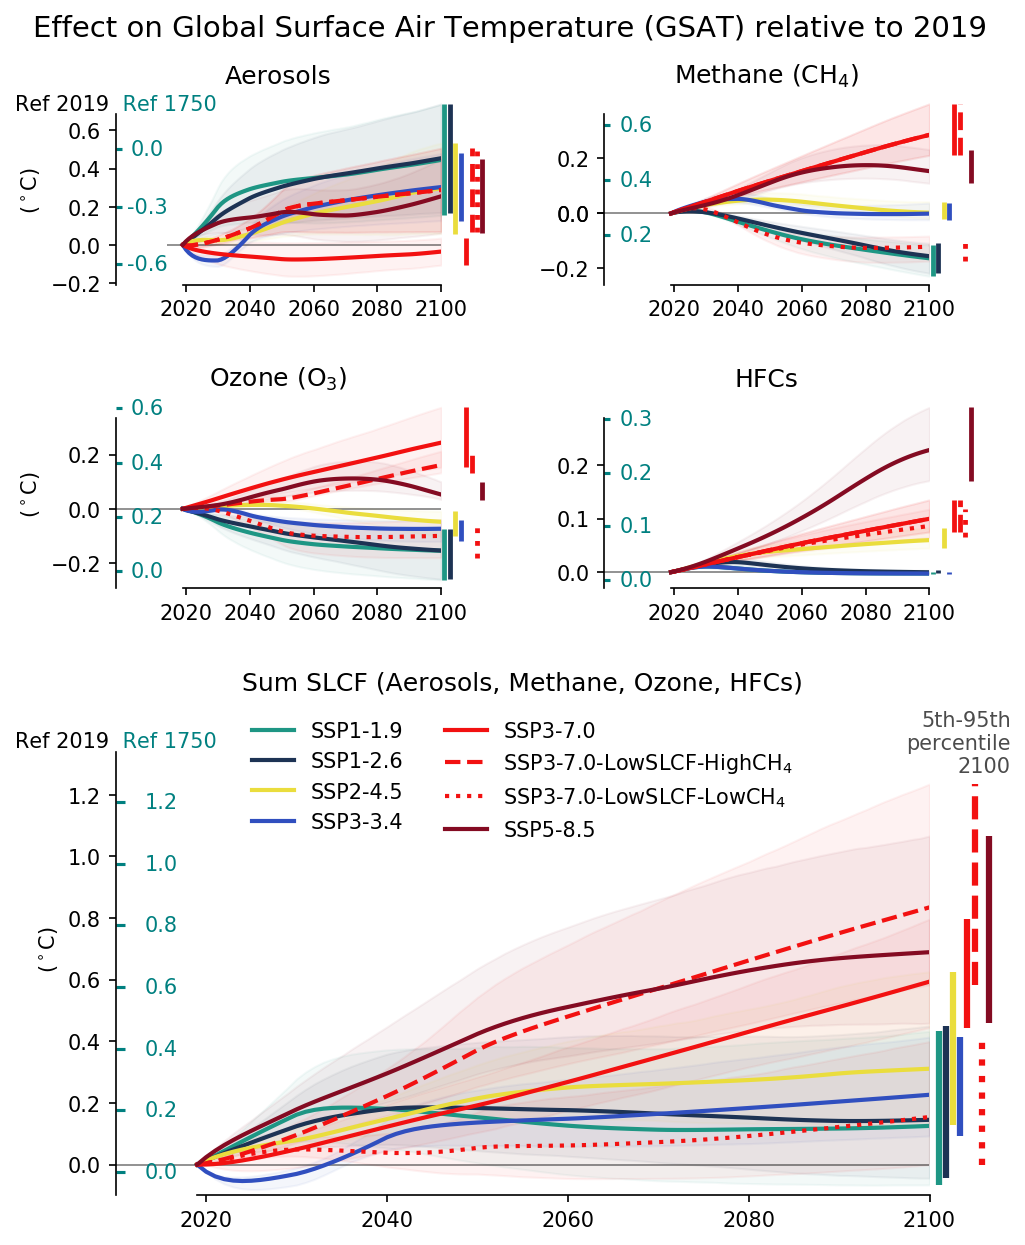

In [26]:
figsize = [7, 9]  # [6, 4]
s_y = ref_year
s_y2 = 2019

e_y2 = last_y
# scenario colors and linestyle
cdic = get_scenario_c_dic()
lsdic = get_scenario_ls_dic()  # get_ls_dic(ds_DT[climatemodel].values)

linewidth = 2

fig2, axs, ax_tot = get_fig_ax_tot(fgsize=figsize, rows_tot=2, cols_tot=0, ncols=2,
                                   orientation='vertical',
                                   tot_first=False)

# fig3 = plt.figure(constrained_layout=True)
_ds = ds_DT.sel(year=slice(s_y2, e_y2))
for var, ax in zip(variables_erf_comp, axs):

    print(var)

    # fig, ax = plt.subplots(1, 1, figsize=figsize)
    for scn in scenarios_fl:  # list(set(scenarios_fl) - {'historical'}):
        # compute difference from ref year:
        _da_ally = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(s_y2, e_y2))
        _da_refy = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(s_y, s_y)).squeeze()
        _da = _da_ally - _da_refy
        # Choose median:
        _pl_da = _da.sel(percentile=recommendation)
        # Plot mean:
        _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle=lsdic[scn], linewidth=linewidth)

    # various labels:
    ax.set_title('%s' % get_var_nicename(var))

    ax.set_xlabel('')
    ax.set_ylabel('')
    # Plot zero line:
    if 'aerosol' in var:
        ax.hlines(0, 2014, 2100, linewidth=.8, alpha=0.5)
    else:
        ax.hlines(0, 1990, 2100, linewidth=.8, alpha=0.5)

    # ax.plot(_ds['year'], np.zeros(len(_ds['year'])), c='k', alpha=0.5, linestyle='dashed')
    add_uncertainty_bar(ax, var, linewidth=2.3, i_plus=1.7)
    fix_ax(ax)
    ax.spines['bottom'].set_bounds(2019, 2100)
    bound_yax(ax)
    ax.set_xlim([1998, 2100])
    set_ylim_sec_ax(ds_dt_2019, var, ax, ref_year=1750, ref_y_first_ax=2019)
    ax.set_yticks(ytick_dic[var])
    ax.set_xticks(ls_xticks)

add_reftext(axs[0])

for ax in axs[0::2]:
    ax.set_ylabel('($^\circ$C)')

if len(axs) > len(variables_erf_comp):
    l = len(variables_erf_comp)
    for i in range(l, len(axs)):
        axs[l].axis('off')

# Total:

ax = ax_tot

cdic = get_scenario_c_dic()
# for var in variables_erf_tot:  # , f_totn]:
for scn in scenarios_fl:  # list(set(scenarios_fl) - {'historical'}):
    # Plot dataset difference to first year, i.e.
    ds_DT_sy = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable).sel(scenario=scn,
                                                                                     year=slice(s_y, s_y)).squeeze()
    _da = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable).sel(scenario=scn,
                                                                                year=slice(s_y2, e_y2)) - ds_DT_sy
    # Take median::
    _pl_da = _da.sel(percentile=recommendation)
    _pl_da.plot(ax=ax, c=cdic[scn], label=trans_scen2plotlabel(scn), linestyle=lsdic[scn], linewidth=linewidth)

var = 'Sum SLCF (Aerosols, Methane, Ozone, HFCs)'

add_uncertainty_bar(ax, var, linewidth=3,
                    i_plus=.8)
_ds = ds_DT.sel(year=slice(s_y2, e_y2))
# ax.plot(_ds['year'], np.zeros(len(_ds['year'])), c='k', alpha=0.5, linestyle='dashed')
plt.suptitle('Effect on Global Surface Air Temperature (GSAT) relative to 2019', fontsize=14, y=1.0)
# adjust plot visuals:
_str = ''
_vl = [get_var_nicename(var).split('(')[0].strip() for var in variables_erf_comp]
for var in _vl: _str += f'{var}, '
ax.set_title('Sum SLCF (%s)' % _str[:-2])
ax.hlines(0, 1990, 2100, linewidth=.8, alpha=0.5)

# ax.set_ylabel('$\Delta$ T ($^\circ$C)')
ax.set_ylabel('($^\circ$C)')
ax.set_xlabel('')

fix_ax(ax)
ax.spines['bottom'].set_bounds(2019, 2100)
ax.set_xlim([2010, 2100])
add_reftext(ax)
ax.text(1.1, .85,
        '5th-95th\npercentile\n2100',
        ha='right',
        va='bottom',
        alpha=.7,
        transform=ax.transAxes)
var = 'Sum SLCF (Aerosols, Methane, Ozone, HFCs)'
ax.set_ylim([-.1, 1.5])
diff = set_ylim_sec_ax(ds_dt_2019, var, ax, ref_year=1750, ref_y_first_ax=2019, adj=5, l_tick=1, xlim=[2010, 2100])
ax.set_yticks(ytick_dic[var])
ax.set_xticks(ls_xticks)

ax.legend(frameon=False, loc='upper center', ncol=2)
plt.subplots_adjust(top=0.94, left=0.125, wspace=.5, hspace=.6)
# plt.tight_layout()# w_pad=4)#rect=[0,0,.94,1],
plt.savefig(FIGURE_DIR / 'total_ref2019_from2015_all_2.png', dpi=300, bbox_inches='tight')
plt.savefig(FIGURE_DIR / 'total_ref2019_from2015_all_2.pdf', bbox_inches='tight')  # , dpi=300)
plt.show()

In [27]:
import seaborn as sns

aerosol-total-with_bc-snow


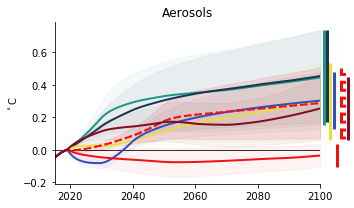

ch4


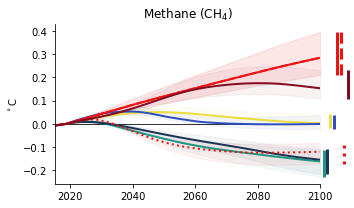

o3


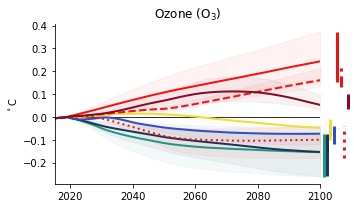

HFCs


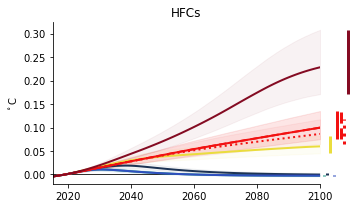

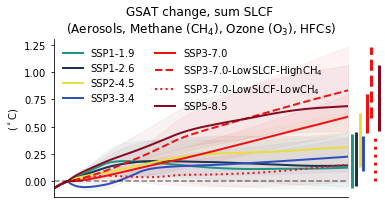

In [28]:
from ar6_ch6_rcmipfigs.utils.plot import trans_scen2plotlabel

# get_fig_ax_tot

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ar6_ch6_rcmipfigs.utils.misc_func import make_folders

figsize = [5, 3]
s_y = ref_year
s_y2 = '2015'
e_y = last_y
e_y2 = last_y
# scenario colors and linestyle
cdic = get_scenario_c_dic()
lsdic = get_scenario_ls_dic()  # get_ls_dic(ds_DT[climatemodel].values)

linewidth = 2

# fig2, axs, ax_tot = get_fig_ax_tot()#fig3 = plt.figure(constrained_layout=True)
_ds = ds_DT.sel(year=slice(s_y2, e_y2))
for var in variables_erf_comp:  # , axs):

    print(var)

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for scn in scenarios_fl:  # list(set(scenarios_fl) - {'historical'}):
        # compute difference from ref year:
        _da_ally = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(s_y2, e_y2))
        _da_refy = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(s_y, s_y)).squeeze()
        _da = _da_ally - _da_refy
        # Choose median: 
        _pl_da = _da.sel(percentile=recommendation)
        # Plot mean: 
        _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle=lsdic[scn], linewidth=linewidth)

    # various labels:
    ax.set_title('%s' % get_var_nicename(var))
    ax.set_ylabel('$^\circ$C')
    ax.set_xlabel('')
    fix_ax(ax)
    # Plot zero line:
    # ax.plot(_ds['year'], np.zeros(len(_ds['year'])), c='k', alpha=0.5, linestyle='dashed')
    plt.hlines(0, 2014, 2100, linewidth=.8)
    # figname
    fign = FIGURE_DIR / fign_dt(var, s_y, s_y2)
    make_folders(str(fign))
    # add_uncertainty_bar(ax, var, )
    add_uncertainty_bar(ax, var, linewidth=3, i_plus=1.1)

    plt.tight_layout()
    fig.subplots_adjust(right=.9)  # or whatever

    plt.savefig(fign, dpi=300)
    plt.savefig(fign.with_suffix('.pdf'))
    plt.show()

axs[0].set_ylabel('($^\circ$C)')
for ax in axs:
    # ax.set_ylabel('Change in temperature (C$^\circ$)')
    ax.set_ylabel('($^\circ$C)')

fig, ax = plt.subplots(1, 1, figsize=figsize)  # [9,5])

cdic = get_scenario_c_dic()
# for var in variables_erf_tot:  # , f_totn]:
for scn in scenarios_fl:  # list(set(scenarios_fl) - {'historical'}):
    # Plot dataset difference to first year, i.e.
    ds_DT_sy = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable).sel(scenario=scn,
                                                                                     year=slice(s_y, s_y)).squeeze()
    _da = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable).sel(scenario=scn,
                                                                                year=slice(s_y2, e_y2)) - ds_DT_sy
    # Take median::
    _pl_da = _da.sel(percentile=recommendation)
    _pl_da.plot(ax=ax, c=cdic[scn], label=trans_scen2plotlabel(scn), xticks=[], linestyle=lsdic[scn],
                linewidth=linewidth)
var = 'Sum SLCF (Aerosols, Methane, Ozone, HFCs)'

add_uncertainty_bar(ax, var, linewidth=3, i_plus=1.1)

# adjust plot visuals:
_str = ''
for var in ds_DT.sel(variable=variables_erf_comp)[variable].values: _str += f'{get_var_nicename(var)}, '
ax.set_title('GSAT change, sum SLCF \n(%s)' % _str[:-2])

ax.set_ylabel('($^\circ$C)')
ax.set_xlabel('')

ax.legend(frameon=False, loc=2, ncol=2)
fix_ax(ax)
_ds = ds_DT.sel(year=slice(s_y2, e_y2))
ax.plot(_ds['year'], np.zeros(len(_ds['year'])), c='k', alpha=0.5, linestyle='dashed')

plt.tight_layout()
fn = FIGURE_DIR / fign_dt('total', s_y, s_y2)
plt.savefig(fn, dpi=200)
plt.savefig(fn.with_suffix('.pdf'))  # , dpi=200)
plt.show()

# Supplementary plots:

## Plot $\Delta$ T and ERF with reference year +/- 1 standard deviation of the models

In [29]:
scenarios_fl = ['ssp119',
                'ssp126',
                'ssp245',

                # 'ssp370',
                'ssp370-lowNTCF-aerchemmip',
                'ssp370-lowNTCF-gidden',
                'ssp585']

In [30]:
ref_year

'2019'

aerosol-total-with_bc-snow


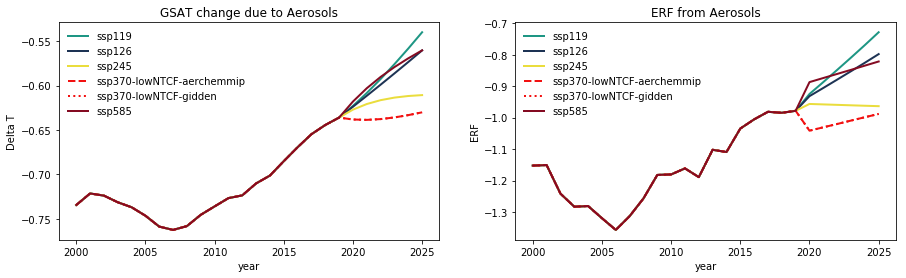

ch4


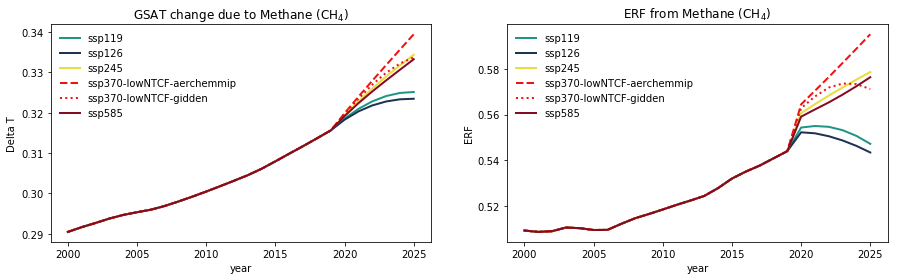

o3


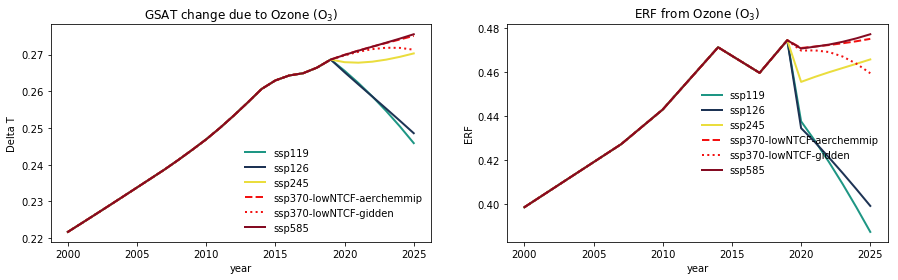

HFCs


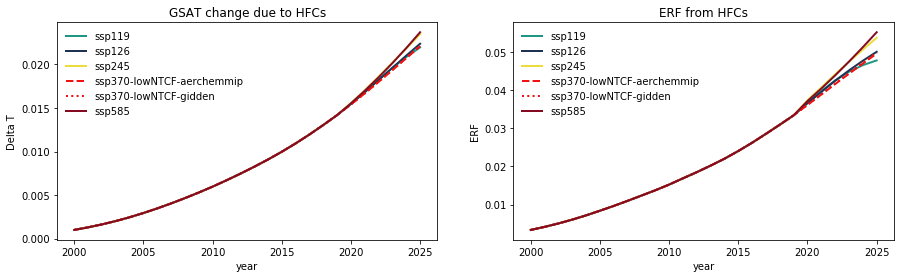

In [31]:
from ar6_ch6_rcmipfigs.utils.plot import get_scenario_ls_dic, get_scenario_c_dic

# Get linestyle scenarios:
lsdic = get_scenario_ls_dic()  # get_ls_dic(ds_DT[climatemodel].values)
s_y = ref_year
s_y2 = '2015'
e_y = last_y
e_y2 = last_y
# Get colorscheme scenarios
cdic = get_scenario_c_dic()
alpha = 0.3
for var in variables_erf_comp:
    fig, axs = plt.subplots(1, 2, figsize=[15, 4])
    for scn in scenarios_fl:  # ) - {'historical'}):
        first = True

        _da1 = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(2000, 2025)).sel(percentile=recommendation)
        _da2 = ds_DT['ERF'].sel(variable=var, scenario=scn, year=slice(2000, 2025))
        for _da, ax in zip([_da1, _da2], axs):
            _pl_da = _da  # .sel(percentile='median')#.mean(climatemodel)
            _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle=lsdic[scn], linewidth=2)
    print(var)

    axs[0].set_title('GSAT change due to %s' % get_var_nicename(var))
    axs[1].set_title('ERF from %s' % get_var_nicename(var))

    axs[0].legend(frameon=False)  # , loc=2)
    axs[1].legend(frameon=False)  # , loc=2)

    plt.show()

Subtracting year 2019, while still plotting from 2015. Thus the results represent the cooling/warming with respect to year 2020

aerosol-total-with_bc-snow


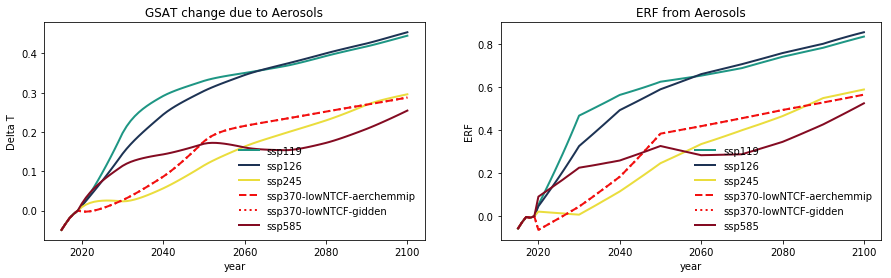

ch4


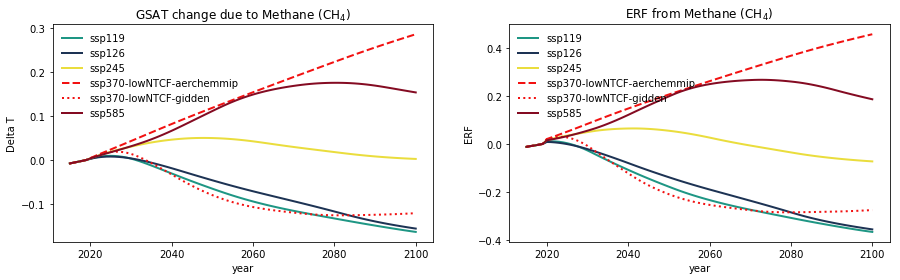

o3


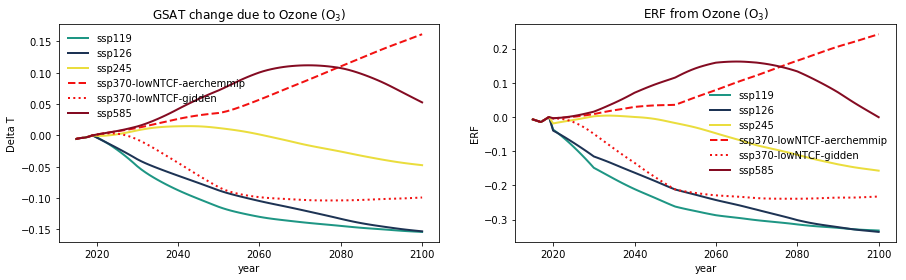

HFCs


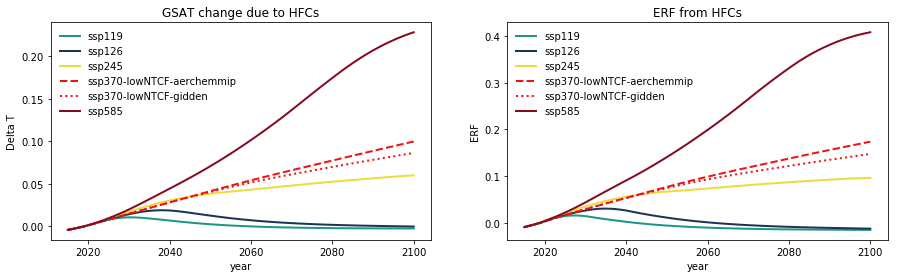

In [32]:
from ar6_ch6_rcmipfigs.utils.plot import get_scenario_ls_dic, get_scenario_c_dic

# Get linestyle scenarios:
lsdic = get_scenario_ls_dic()  # get_ls_dic(ds_DT[climatemodel].values)

s_y = ref_year
s_y2 = '2015'
e_y = last_y
e_y2 = last_y
# Get colorscheme scenarios
cdic = get_scenario_c_dic()
alpha = 0.3
for var in variables_erf_comp:
    fig, axs = plt.subplots(1, 2, figsize=[15, 4])
    for scn in scenarios_fl:  # ) - {'historical'}):
        first = True
        _da1 = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(s_y2, e_y2)) - ds_DT[name_deltaT].sel(
            variable=var, scenario=scn,
            year=slice(s_y, s_y)).squeeze()
        _da1 = _da1.sel(percentile=recommendation)
        _da2 = ds_DT['ERF'].sel(variable=var, scenario=scn, year=slice(s_y2, e_y2)) - ds_DT['ERF'].sel(variable=var,
                                                                                                       scenario=scn,
                                                                                                       year=slice(s_y,
                                                                                                                  s_y)).squeeze()
        for _da, ax in zip([_da1, _da2], axs):
            _pl_da = _da  # .sel(percentile='median')#.mean(climatemodel)
            _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle=lsdic[scn], linewidth=2)
    print(var)

    axs[0].set_title('GSAT change due to %s' % get_var_nicename(var))
    axs[1].set_title('ERF from %s' % get_var_nicename(var))

    axs[0].legend(frameon=False)  # , loc=2)
    axs[1].legend(frameon=False)  # , loc=2)

    plt.show()